In [1]:
# TODO Drop RXE from training centre!
import joblib
import math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix

from cogpred.utils.configuration import get_config
from cogpred.utils.naming import make_run_path
from cogpred.loading import make_training_data

config = get_config()
conn_dir = config["connectivity_matrices"]
sns.reset_defaults()
ATLAS = "schaefer200"
k = 3

In [2]:
import sys
import os
bpath = Path(os.environ["HOME"]) / "AD-prediction"
sys.path.append(str(bpath))
from bold_dementia.data.volumes import add_volumes, load_volumes


In [3]:
_, metadata = make_training_data(conn_dir, ATLAS, k)

run_path = make_run_path(config["output_dir"], k=k, feat="volumetry", atlas=ATLAS, experimental=False)
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 8 subjects because of lacking MMMSE


In [4]:
vpath = Path(config["data_dir"]) / "volumes.csv"
df = add_volumes(metadata, vpath)

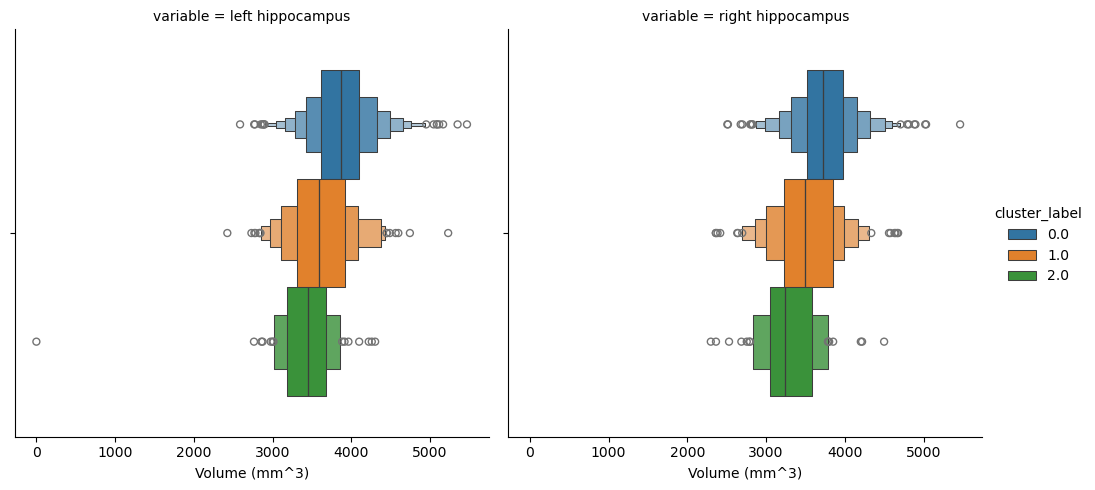

In [5]:
m = df.melt(
    id_vars=["cluster_label"],
    value_vars=["left hippocampus", "right hippocampus"],
    value_name="Volume (mm^3)"
)
sns.catplot(m, x="Volume (mm^3)", hue="cluster_label", col="variable", kind="boxen", palette="tab10")
plt.show()

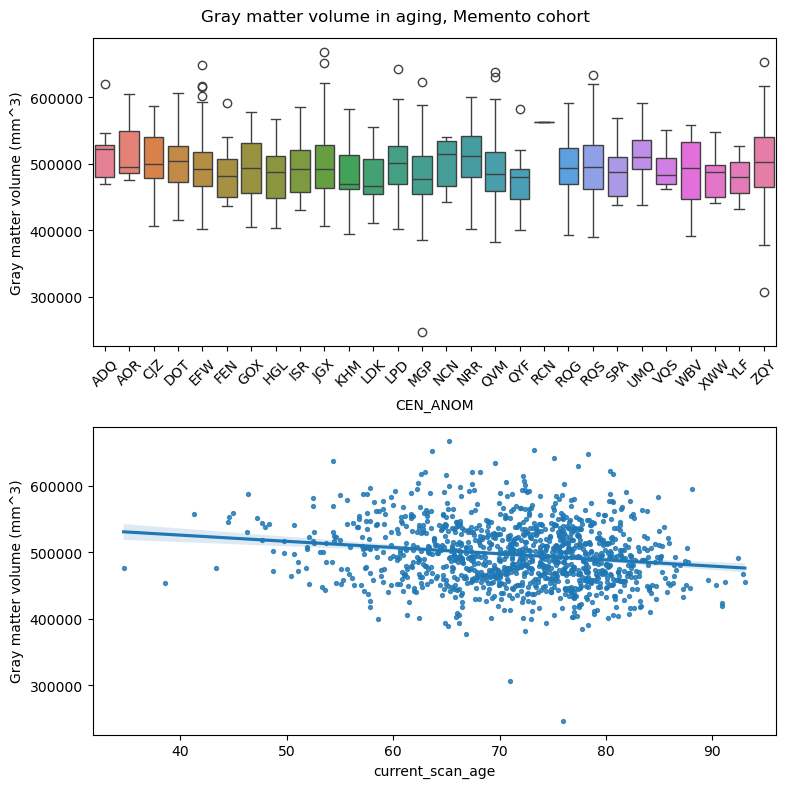

In [6]:
df["gray matter volume"] = df['left cerebral cortex'] + df['right cerebral cortex']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharey=True)
sns.boxplot(
    df.groupby("sub").sample(n=1).sort_values(by="CEN_ANOM"),
    y='gray matter volume',
    x='CEN_ANOM',
    hue="CEN_ANOM",
    ax=ax1
)
ax1.tick_params(axis='x', labelrotation=45)

sns.regplot(
    df.groupby("sub").sample(n=1),
    x="current_scan_age",
    y='gray matter volume',
    scatter_kws=dict(s=8),
    ax=ax2
)
ax1.set_ylabel("Gray matter volume (mm^3)")
ax2.set_ylabel("Gray matter volume (mm^3)")
fig.suptitle("Gray matter volume in aging, Memento cohort")
fig.tight_layout()
plt.show()

In [7]:
y = metadata.cluster_label
assert len(df) == len(y)

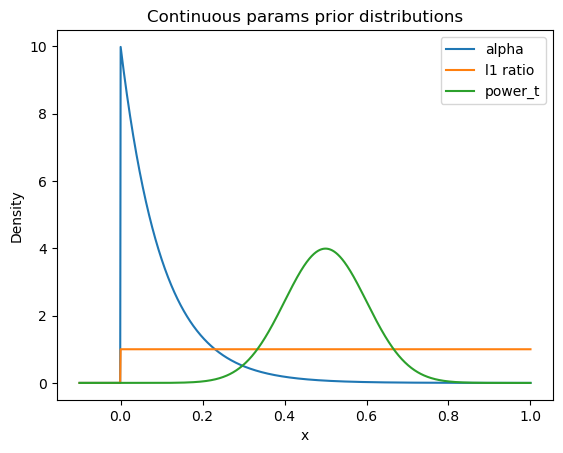

In [8]:
from scipy import stats

#lambda_param = 1 / 1e-4
lambda_param = 10
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
#l1_ratio = stats.beta(1.5, 3) # TODO Try higher l1_ratio with high n_comps
#l1_ratio = stats.expon(scale=1/7)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)

plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()



In [9]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
}

In [10]:
# on en était ici
# TODO What timepoint? Can we be sure it's the first one?

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn import preprocessing as preproc

cortex_selec = make_column_selector(
    pattern="ctx-.*",
    dtype_include=float
)
transformers = (
    ("cortex", preproc.StandardScaler(), cortex_selec),
    (
        "subcortical",
        preproc.StandardScaler(),
        ["left hippocampus", "right hippocampus"]
    ), # TODO Ventricles?
)
ct = ColumnTransformer(
    transformers=transformers, remainder="drop"
)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.model_selection import (
    cross_validate, cross_val_predict, KFold, RandomizedSearchCV, StratifiedKFold, GroupShuffleSplit
)

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import cross_val_predict, KFold, RandomizedSearchCV, cross_val_score
from cogpred.supervised import macro_f1

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)

clf = Pipeline(
    [
    ("ct", ct),
    ("classifier", sgd)
    ],
    verbose=False
)

inner_cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=1999)

outer_cv = GroupShuffleSplit(n_splits=8, random_state=1999)


search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [12]:
search.fit(df, y)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
79,0.083484,0.011681,0.009284,0.005270,0.045467,0.380861,modified_huber,0.502392,"{'classifier__alpha': 0.04546733191293006, 'cl...",0.385336,0.430682,0.483760,0.456620,0.394993,0.402383,0.467767,0.429257,0.431350,0.033531,1
41,0.057517,0.005796,0.007900,0.001631,0.034320,0.142226,log_loss,0.562910,"{'classifier__alpha': 0.034319934663027234, 'c...",0.426872,0.447901,0.431262,0.395596,0.362670,0.457212,0.471310,0.444384,0.429651,0.032981,2
86,0.096676,0.018318,0.007947,0.000952,0.036719,0.414635,modified_huber,0.672874,"{'classifier__alpha': 0.036719188126644355, 'c...",0.378848,0.427068,0.501945,0.460067,0.396543,0.356312,0.470341,0.443333,0.429307,0.046173,3
23,0.060059,0.007724,0.007770,0.001567,0.023019,0.442006,log_loss,0.471093,"{'classifier__alpha': 0.02301913366277109, 'cl...",0.398131,0.424357,0.468593,0.475203,0.347980,0.470620,0.422983,0.408897,0.427095,0.040903,4
15,0.113158,0.018920,0.007080,0.000519,0.030618,0.699453,modified_huber,0.343538,"{'classifier__alpha': 0.030618256512287695, 'c...",0.390043,0.417711,0.479233,0.447896,0.424818,0.344555,0.446659,0.447386,0.424788,0.039022,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,0.032646,0.004435,0.006937,0.000606,0.181214,0.662580,hinge,0.369455,"{'classifier__alpha': 0.18121417341224122, 'cl...",0.291824,0.291824,0.291824,0.291508,0.291508,0.291508,0.291508,0.291508,0.291627,0.000153,83
54,0.035165,0.004047,0.008121,0.000966,0.315500,0.255865,hinge,0.717394,"{'classifier__alpha': 0.31549987382496675, 'cl...",0.291824,0.291824,0.291824,0.291508,0.291508,0.291508,0.291508,0.291508,0.291627,0.000153,83
58,0.037510,0.002605,0.007497,0.000332,0.107102,0.683930,hinge,0.423776,"{'classifier__alpha': 0.10710241069441317, 'cl...",0.291824,0.291824,0.291824,0.291508,0.291508,0.291508,0.291508,0.291508,0.291627,0.000153,83
70,0.029051,0.001016,0.007246,0.000344,0.228173,0.834925,hinge,0.441116,"{'classifier__alpha': 0.22817275444301358, 'cl...",0.291824,0.291824,0.291824,0.291508,0.291508,0.291508,0.291508,0.291508,0.291627,0.000153,83


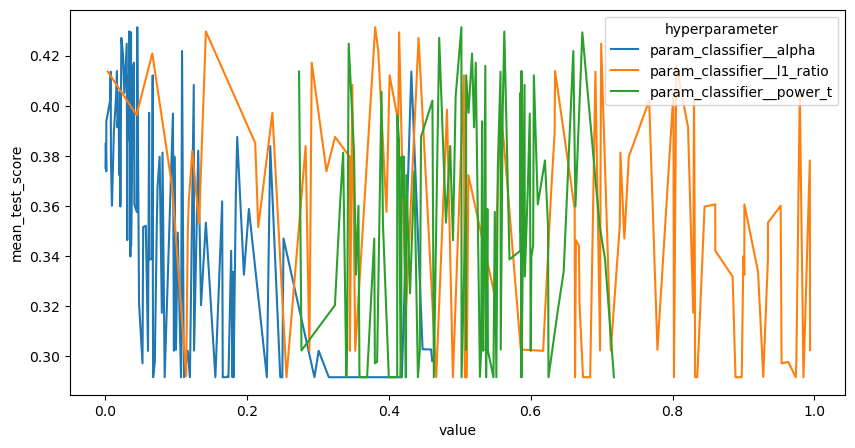

In [13]:
m = cv_results.melt(
    id_vars='mean_test_score',
    value_vars=[
        "param_classifier__alpha",
        "param_classifier__l1_ratio",
        "param_classifier__power_t"
    ],
    var_name="hyperparameter"
)
plt.subplots(figsize=(10, 5))
sns.lineplot(
    m,
    x="value",
    y="mean_test_score",
    hue="hyperparameter"
)
plt.show()

In [14]:
test_scores = cross_val_score(
    search, df, y, cv=outer_cv.split(df, y, groups=metadata.CEN_ANOM.values), n_jobs=8, scoring=macro_f1, verbose=1
) # TODO Get hyperparameters
test_scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

array([0.48641436, 0.44463041, 0.38247038, 0.3882404 , 0.44174186,
       0.42152047, 0.33052476, 0.39738072])

In [15]:
from sklearn.dummy import DummyClassifier
baseline_scores = cross_val_score(
    DummyClassifier(), df, y, cv=outer_cv.split(df, y, groups=metadata.CEN_ANOM.values), n_jobs=8, scoring=macro_f1, verbose=1
) # TODO Get hyperparameters
dummy_run_path = make_run_path(config["output_dir"], k=k, feat="dummy", experimental=False)
os.makedirs(dummy_run_path, exist_ok=True)
joblib.dump(baseline_scores, dummy_run_path / "test_scores.joblib")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-dummy_experimental-False/test_scores.joblib']

In [16]:
joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-volumetry_atlas-schaefer200_experimental-False/best_estimator.joblib']